# Freeze Bert Model Using CLS Token
### **Genre label: 8**
### **Data: Unbalance || train_df**
### **Bert Model: Case**

In [ ]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Loading the Dataset and Encoding the Text

In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/train_df.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/validation_df.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/test_df.pkl')

In [ ]:
# getting the training, validation, and test text
train_text = train_df['lyrics'].tolist()
validation_text = validation_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

# getting the training, validation, and test label
train_label = train_df['mapped_genres'].tolist()
validation_label = validation_df['mapped_genres'].tolist()
test_label = test_df['mapped_genres'].tolist()

In [ ]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
validation_text = [preprocess_text(text) for text in validation_text]
test_text = [preprocess_text(text) for text in test_text]

In [ ]:
# encoding the labels
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
validation_label = encode_label.fit_transform(validation_label)
test_label = encode_label.fit_transform(test_label)

In [ ]:
# initializeing TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features= 10000)

# fit and transform the text
X_train = tfidf_vectorizer.fit_transform(train_text)
X_val = tfidf_vectorizer.transform(validation_text)
X_test = tfidf_vectorizer.transform(test_text)

In [ ]:
# scaling tf-idf feature
scaler = StandardScaler(with_mean = False)
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

# Bert Model

In [ ]:
from transformers import BertTokenizer, TFBertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
word_len = [len(w.split()) for w in train_text]

sum(word_len) / len(word_len)

248.5789916798732

In [ ]:
MAX_SEQUENCE_LENGTH = 250

In [ ]:
#@title BERT Tokenization of training and val data

bert_train_tokenized = bert_tokenizer(train_text,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_label)

NameError: name 'train_text' is not defined

In [ ]:
bert_val_tokenized = bert_tokenizer(validation_text,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
                     bert_val_tokenized.token_type_ids,
                     bert_val_tokenized.attention_mask]
bert_val_labels = np.array(validation_label)

In [ ]:
bert_train_tokenized.input_ids[0]

<tf.Tensor: shape=(250,), dtype=int32, numpy=
array([  101,  5398,  1112,  1128,  1338,  1107,  1155,  1103,  8839,
        1355,  1283,  1220,  3535,  1115,  1128,   112,  1231,  3258,
        7911,  6174,  1128,  1817,  1173,  1435,  1171,  1111,  1167,
        1109, 16024,  7311,  1106,  1712,  1366,  1155,  8264,  1262,
         146,  1431,  1138,  1227,  1249,  1770,  1112,  1128,  1338,
        1107,  1103, 13965,  1122,  1355,  1283,   146,  3535,  1184,
        1128,  4307,  1106,  1917,  1195,  2910,  1105,  1167,  1262,
        1103, 16024,  7311,  1106,  1712,  1366,  1155,  8264,  1262,
         146,  1431,  1138,  1227,  1135,  1178,  2274,  1141,  2549,
        1104,  1240, 14131,  1106,  1243,  1228,  1706,  3277,  1412,
        1282,  1313,  1114,  1128,  1253,  1103,  1269,  1461,  1249,
        1770,  1112,  1128,  1338,  1107,  2181,  1165,   146,  2059,
        1195,  1241,  7573,  1736,  1262,  1103, 16024,  7311,  1106,
        1712,  1366,  1155,  8264,  1262,   

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/w266/266 Final Project/model_checkpoints/'
bert_last_layer_num = 11

In [ ]:
#@title Freeze Bert Classification Model using CLS

def freeze_bert_model_with_CLS(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=2e-5,
                          last_layer_num=11
                       ):
    # freezing all bert layers except the last transformer block
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(8, activation='softmax',name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics='accuracy')

    return classification_model

In [ ]:
#calculate sample weights
sample_weight = np.ones(shape=(len(bert_train_labels),))
for label in range(np.max(bert_train_labels) + 1):
    class_weight = 1 - np.sum(bert_train_labels == label) / len(bert_train_labels)
    sample_weight[bert_train_labels == label] = class_weight


# setting up check points
checkpoint_prefix = checkpoint_dir + 'bert_weights_%s'
checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)


bert_model_2 = freeze_bert_model_with_CLS(
    bert_model,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=100,
    dropout=0.3,
    learning_rate=2e-5,
    last_layer_num=bert_last_layer_num
)

bert_model_2 = freeze_bert_model_with_CLS(bert_model)
bert_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 250)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                    

In [ ]:
bert_model_2.fit(
    bert_train_inputs,
    bert_train_labels,
    sample_weight=sample_weight,
    validation_data=(bert_val_inputs, bert_val_labels),
    epochs=3,
    batch_size = 8,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/3


5048/5048 [==============================] - 1065s 209ms/step - loss: 1.3299 - accuracy: 0.3940 - val_loss: 1.4213 - val_accuracy: 0.4588
Epoch 2/3
5048/5048 [==============================] - 1050s 208ms/step - loss: 1.2129 - accuracy: 0.4472 - val_loss: 1.3858 - val_accuracy: 0.4717
Epoch 3/3
5048/5048 [==============================] - 992s 196ms/step - loss: 1.1715 - accuracy: 0.4659 - val_loss: 1.3529 - val_accuracy: 0.4893


In [ ]:
val_predictions = bert_model_2.predict(bert_val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(bert_val_labels, val_predictions, target_names=encode_label.classes_))

158/158 [==============================] - 96s 587ms/step
                precision    recall  f1-score   support

   Alternative       0.60      0.68      0.63      1186
Country & Folk       0.36      0.37      0.37       507
    Electronic       0.40      0.27      0.32       611
 Hip Hop & Rap       0.79      0.86      0.82       246
  Jazz & Blues       0.37      0.17      0.23       101
           Pop       0.45      0.67      0.54      1001
          Rock       0.44      0.34      0.38      1129
   Soul & Funk       0.36      0.10      0.16       267

      accuracy                           0.49      5048
     macro avg       0.47      0.43      0.43      5048
  weighted avg       0.48      0.49      0.47      5048



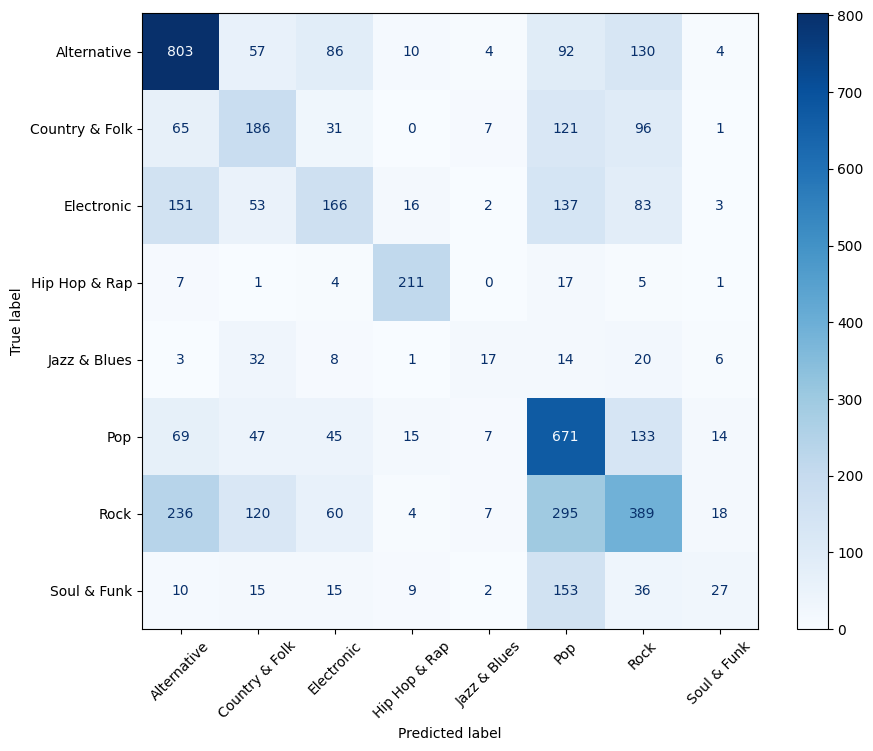

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(bert_val_labels, val_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encode_label.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#@title Error Analysis on Freeze Bert Classification Model

true_labels = pd.Series(bert_val_labels, name="True Label")
pred_labels = pd.Series(val_predictions, name="Predicted Label")

error_analysis_df = pd.concat([true_labels, pred_labels], axis=1)

misclassified = error_analysis_df[error_analysis_df["True Label"] != error_analysis_df["Predicted Label"]]
misclassified_indices = misclassified.index

print("Some misclassified examples:")
print(misclassified.head())

Some misclassified examples:
    True Label  Predicted Label
0            7                5
7            5                6
8            6                2
9            0                1
11           1                5


In [ ]:
# getting the tokenize sequence and converting it back to text to look at the gener that its miss classfying
def decode_text(sequence, tokenizer):
    return tokenizer.decode(sequence, skip_special_tokens=True)

print("Some misclassified examples with text:")
for idx in misclassified_indices[:5]:
    input_ids = bert_val_inputs[0][idx]
    true_label = encode_label.classes_[bert_val_labels[idx]]
    predicted_label = encode_label.classes_[val_predictions[idx]]
    decoded_text = decode_text(input_ids, bert_tokenizer)

    print(f"Text: {decoded_text}")
    print(f"True Genre: {true_label}, Predicted Genre: {predicted_label}")
    print("-" * 100)


Some misclassified examples with text:
Text: Your words alone could drive me to A thousand tears All the same words that kept me here For all the years I'm lost again it's happening When you're around I just go away All I wanna know is it mutual? Then I never want to leave Then I'm ready to run ready to fall Think I'm ready to loose it all Then I'm ready to run ready to fall Think I'm ready to loose it all Keep me running you keep me running Keep me running you keep me running Keep me running you keep me running Keep me running you keep me running you keep me Whoa would you hold my hand like the air it's so gently here? Never give up, never give up Whoa would you pull me closer and nobody knows we're there No one can find us I'm lost again, it's happening When you're around I just go away All I wanna know is it mutual? Then I never want to leave Then I'm ready to run ready to fall Think I'm ready to loose it all Then I'm ready to run ready to fall Think I'm ready to loose it all Keep m

In [ ]:
train_df_copy = train_df.copy()

one_hot_genres = pd.get_dummies(train_df_copy['mapped_genres'], prefix='genre')
train_df_copy = pd.concat([train_df_copy, one_hot_genres], axis=1)
train_df_copy.head()

,id,genres,tags,lang,artist,song,album_name,spotify_id,popularity,release,...,lyrics_id,lyrics,genre_Alternative,genre_Country & Folk,genre_Electronic,genre_Hip Hop & Rap,genre_Jazz & Blues,genre_Pop,genre_Rock,genre_Soul & Funk
0,0YBEBBsvEhueTFKs,"[metal, alternative metal, alternative rock, n...","[metal, alternative metal, deftones, alternati...",en,Deftones,Deathblow,Deftones,09QuitJuAP87RoBSpiCXPs,37.0,2003,...,0YBEBBsvEhueTFKs,Soon as you came in all the beast went away\nT...,True,False,False,False,False,False,False,False
1,iyxKHmSwk4upK59f,"[rock, classic rock, hard rock]","[rock, classic rock, queen, hard rock]",en,Queen,Ride the Wild Wind,Innuendo,7rkrEyowp24CGvy0vE3snq,22.0,1991,...,iyxKHmSwk4upK59f,"Ride the wild wind\n(Push the envelope, don't ...",False,False,False,False,False,False,True,False
2,Pt8zYJlZoAfSrJVD,[rap],"[trap, rap, hip-hop, rnb]",en,YNW Melly,Rolling Loud,We All Shine,1wX1DO1MBKec6DeWpTe6fM,57.0,2019,...,Pt8zYJlZoAfSrJVD,"Hey, hey\nYou know the mountains and the sun f...",False,False,False,True,False,False,False,False
3,NnsTQ8qIJeARR2PX,[rock],"[rock, holiday]",en,Ash,Pacific Palisades,Free All Angels,5tvLu5uwx0ObRyJgOCZjX5,12.0,1998,...,NnsTQ8qIJeARR2PX,You were standing on the shore\nListening to t...,False,False,False,False,False,False,True,False
4,0hhgAPscs36TcQI6,[folk],"[folk, songs, guud]",en,Mount Eerie,I Have Been Told That My Skin Is Exceptionally...,Dawn,57rro2VcnlGgDu9l7QWXic,17.0,2004,...,0hhgAPscs36TcQI6,Should there be songs?\nShould my hair be long...,False,True,False,False,False,False,False,False


In [ ]:
def change_column_name(col_name):
  return col_name.replace(" ", "_").title().lower()

train_df_copy.columns = [change_column_name(col) for col in train_df_copy.columns]
print(train_df_copy.columns)


Index(['id', 'genres', 'tags', 'lang', 'artist', 'song', 'album_name',
       'spotify_id', 'popularity', 'release', 'danceability', 'energy', 'key',
       'mode', 'valence', 'tempo', 'duration_ms', 'mapped_genres', 'lyrics_id',
       'lyrics', 'genre_alternative', 'genre_country_&_folk',
       'genre_electronic', 'genre_hip_hop_&_rap', 'genre_jazz_&_blues',
       'genre_pop', 'genre_rock', 'genre_soul_&_funk'],
      dtype='object')


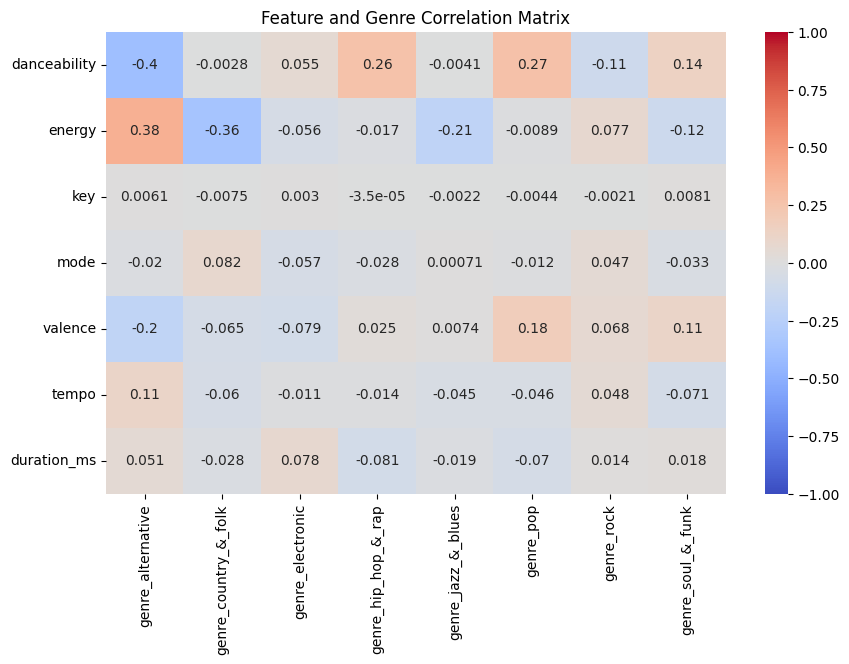

In [ ]:
song_feature = ['danceability', 'energy', 'key', 'mode', 'valence', 'tempo', 'duration_ms']

one_hot_columns = [change_column_name(col) for col in one_hot_genres.columns]
correlation_matrix = train_df_copy[song_feature + one_hot_columns].corr()
genre_correlation_matrix = correlation_matrix[one_hot_columns].loc[song_feature]

plt.figure(figsize=(10, 6))
sns.heatmap(genre_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature and Genre Correlation Matrix')
plt.show()

In [ ]:
import pandas as pd
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):

    text = text.translate(str.maketrans('', '', string.punctuation))

    text = text.lower()

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens


train_df_copy['tokens'] = train_df_copy['lyrics'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
genre_columns = ['genre_alternative', 'genre_country_&_folk', 'genre_electronic', 'genre_hip_hop_&_rap', 'genre_jazz_&_blues', 'genre_pop', 'genre_rock', 'genre_soul_&_funk']

genre_word_counts = {genre: Counter() for genre in genre_columns}

for idx, row in train_df_copy.iterrows():
    tokens = row['tokens']
    for genre in genre_columns:
        if row[genre] == 1:
            genre_word_counts[genre].update(tokens)

word_count_dfs = {genre: pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False) for genre, word_counts in genre_word_counts.items()}

In [ ]:
for genre in genre_columns:
    print(f"Top 10 most common words for {genre}:")
    print(word_count_dfs[genre].head(10))
    print("\n")

Top 10 most common words for genre_alternative:
      word  count
271     im  14597
246   dont   9964
109   know   8492
353  never   7643
347   like   6933
49    time   6829
148    see   6512
6    youre   6440
24     one   6280
293   cant   6258


Top 10 most common words for genre_country_&_folk:
      word  count
66      im   6880
156   dont   5462
345   love   5439
164   know   5334
76    like   4890
89      oh   4396
68     got   3584
425  youre   3510
878     na   3264
488     go   3205


Top 10 most common words for genre_electronic:
      word  count
14      im   8444
285   dont   6930
19    love   6647
38    know   5979
118   like   5043
170     oh   4281
61   youre   4192
67      na   4108
29      go   4012
112   time   3747


Top 10 most common words for genre_hip_hop_&_rap:
      word  count
124     im  13174
158   like   9482
20     got   7997
10    dont   6787
22     get   6103
13    yeah   5584
1     know   5461
68    aint   4384
30   bitch   4354
19   nigga   3875


Top 

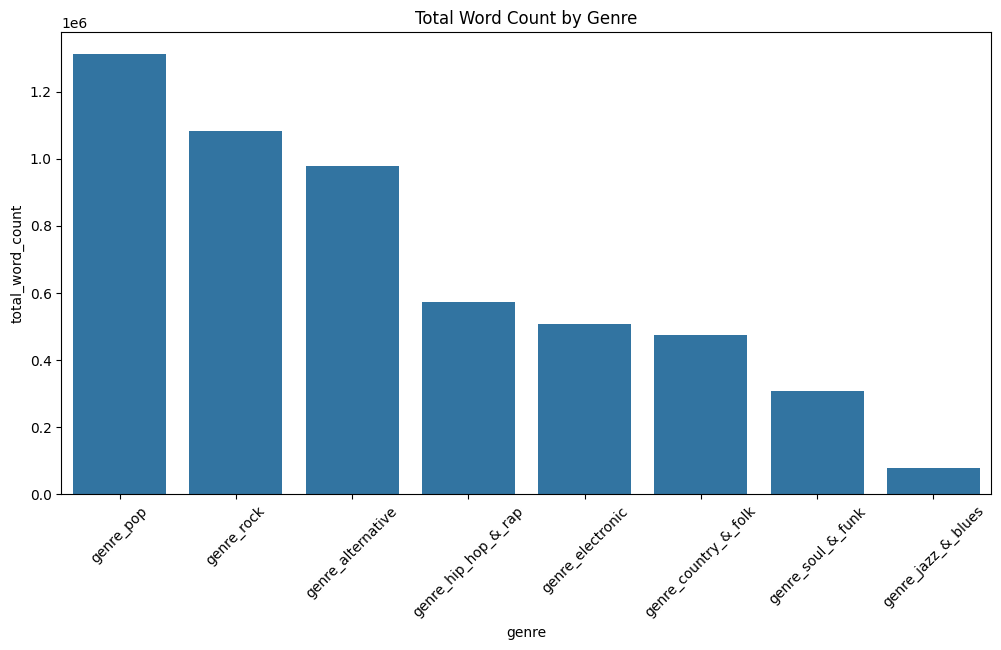

In [ ]:
total_word_counts = {genre: sum(word_counts.values()) for genre, word_counts in genre_word_counts.items()}
total_word_counts_df = pd.DataFrame(list(total_word_counts.items()), columns=['genre', 'total_word_count']).sort_values(by='total_word_count', ascending=False)

total_word_counts_df['genre'] = total_word_counts_df['genre']

plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='total_word_count', data=total_word_counts_df)
plt.title('Total Word Count by Genre')
plt.xticks(rotation=45)
plt.show()